## Load the data

In [23]:
%pip install pandas
%pip install datasets
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
import yfinance as yf
import pandas as pd
import datetime
from datasets import load_dataset

In [25]:
dataset = load_dataset("edarchimbaud/news-stocks")
dataset.set_format(type='pandas')

df = dataset['train'][:]
df

,symbol,body,publisher,publish_time,title,url,uuid
0,A,Vipshop Holdings Limited VIPS is set to report...,Zacks,2023-05-18 16:14:04+00:00,Vipshop (VIPS) to Post Q1 Earnings: What's in ...,https://finance.yahoo.com/news/vipshop-vips-po...,27293957-38d0-3710-8e36-c33a88428202
1,A,"SANTA CLARA, Calif., May 19, 2023--(BUSINESS W...",Business Wire,2023-05-19 01:25:00+00:00,Agilent to Appeal Patent Office Decision on CR...,https://finance.yahoo.com/news/agilent-appeal-...,5477d2fd-f0e0-3721-aeb5-9e4184af5fc1
2,A,Agilent Technologies A is set to report its se...,Zacks,2023-05-19 15:08:03+00:00,Agilent Technologies (A) to Post Q2 Earnings: ...,https://finance.yahoo.com/news/agilent-technol...,619f9fb9-c102-37fc-8b8c-50c11237b9a7
3,A,"Earnings reports from Zoom Video, Lowe’s, Snow...",Barrons.com,2023-05-21 19:00:00+00:00,"Costco, JPMorgan, Snowflake, Ford, Zoom, and M...",https://finance.yahoo.com/m/5f7a781e-1e0c-30b0...,5f7a781e-1e0c-30b0-a052-1d88fc0ce184
4,A,Agilent Technologies A reported second-quarter...,Zacks,2023-05-24 17:17:00+00:00,"Agilent (A) Q2 Earnings Match Estimates, Reven...",https://finance.yahoo.com/news/agilent-q2-earn...,e9307f15-4308-33d8-a649-57f4df3530b1
...,...,...,...,...,...,...,...
22020,ZTS,When considering what names to put on your wat...,Investor's Business Daily,2023-08-09 18:18:00+00:00,Drugmaker Zoetis Stock Shows Rising Relative S...,https://finance.yahoo.com/m/de58f2c0-d31a-310c...,de58f2c0-d31a-310c-a293-02e6c4206e8c
22021,ZTS,"LINCOLN, Neb., August 09, 2023--(BUSINESS WIRE...",Business Wire,2023-08-09 22:33:00+00:00,Zoetis Welcomes Officials to Open New State-of...,https://finance.yahoo.com/news/zoetis-welcomes...,51662184-e4c7-3e7f-a6a2-7b0666de92cd
22022,ZTS,Investors interested in stocks from the Medica...,Zacks,2023-08-10 15:40:11+00:00,USNA or ZTS: Which Is the Better Value Stock R...,https://finance.yahoo.com/news/usna-zts-better...,14a5e82f-6510-30a5-bbf1-cc4982348c42
22023,ZTS,"In this article, we will be taking a look at t...",Insider Monkey,2023-11-09 08:49:40+00:00,Top 20 Drug Companies in the US by Revenue,https://finance.yahoo.com/news/top-20-drug-com...,636f3ccc-872c-3532-ad4b-675b269c4602


In [26]:
from tqdm import tqdm

tickers = list(df['symbol'].unique())

def returns(date):
  # returns are calculated using the close price from the previous trading day
  # and the open price of the next trading day to include the moment when the
  # news was made public (during or outside the trading hours)
  prev_date = prices[prices.index < date].index.max()
  prev_date_index = prices.index.get_loc(prev_date.strftime('%Y-%m-%d'))

  if date.strftime('%Y-%m-%d') == prev_date.strftime('%Y-%m-%d'):
    prev_date_index -= 1

  next_date = prices[prices.index > date].index.min()
  next_date_index = prices.index.get_loc(next_date.strftime('%Y-%m-%d'))

  if date.strftime('%Y-%m-%d') == next_date.strftime('%Y-%m-%d'):
    next_date_index += 1

  # ret = ((prices['Open'][next_date_index] - prices['Close'][prev_date_index]) / prices['Close'][prev_date_index]) * 100
  ret = ((prices.iloc[next_date_index]['Open'] - prices.iloc[prev_date_index]['Close']) / prices.iloc[prev_date_index]['Close']) * 100
  
  return ret

for ticker in tqdm(tickers):
    start_date = df[df['symbol'] == ticker]['publish_time'].min() - datetime.timedelta(days=7)
    end_date = df[df['symbol'] == ticker]['publish_time'].max() + datetime.timedelta(days=7)
    prices = yf.download(ticker, start_date, end_date, progress=False)
    if len(prices) == 0:
      df = df[df['symbol'] != ticker]
      tickers.remove(ticker)
    prices.index = pd.to_datetime(prices.index, format='%Y-%m-%d', utc=True)
    df.loc[df['symbol'] == ticker, 'returns'] = df[df['symbol'] == ticker]['publish_time'].apply(returns)

df

  0%|          | 5/1476 [00:00<02:19, 10.53it/s]
1 Failed download:
['ABC']: Exception('%ticker%: No timezone found, symbol may be delisted')
/var/folders/63/c8pxvvks2_z6m1nd59211gb40000gn/T/ipykernel_54168/4163093376.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<DatetimeArray>
[]
Length: 0, dtype: datetime64[ns, GMT]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['symbol'] == ticker, 'returns'] = df[df['symbol'] == ticker]['publish_time'].apply(returns)
  1%|▏         | 19/1476 [00:01<01:48, 13.37it/s]
1 Failed download:
['ACRX']: Exception('%ticker%: No timezone found, symbol may be delisted')
  9%|▊         | 126/1476 [00:09<01:12, 18.62it/s]
1 Failed download:
['ATHX']: Exception('%ticker%: No timezone found, symbol may be delisted')
  9%|▉         | 132/1476 [00:10<02:10, 10.28it/s]
1 Failed download:
['ATVI']: Exception('%ticker%: No ti

,symbol,body,publisher,publish_time,title,url,uuid,returns
0,A,Vipshop Holdings Limited VIPS is set to report...,Zacks,2023-05-18 16:14:04+00:00,Vipshop (VIPS) to Post Q1 Earnings: What's in ...,https://finance.yahoo.com/news/vipshop-vips-po...,27293957-38d0-3710-8e36-c33a88428202,1.424434
1,A,"SANTA CLARA, Calif., May 19, 2023--(BUSINESS W...",Business Wire,2023-05-19 01:25:00+00:00,Agilent to Appeal Patent Office Decision on CR...,https://finance.yahoo.com/news/agilent-appeal-...,5477d2fd-f0e0-3721-aeb5-9e4184af5fc1,-0.371686
2,A,Agilent Technologies A is set to report its se...,Zacks,2023-05-19 15:08:03+00:00,Agilent Technologies (A) to Post Q2 Earnings: ...,https://finance.yahoo.com/news/agilent-technol...,619f9fb9-c102-37fc-8b8c-50c11237b9a7,-0.371686
3,A,"Earnings reports from Zoom Video, Lowe’s, Snow...",Barrons.com,2023-05-21 19:00:00+00:00,"Costco, JPMorgan, Snowflake, Ford, Zoom, and M...",https://finance.yahoo.com/m/5f7a781e-1e0c-30b0...,5f7a781e-1e0c-30b0-a052-1d88fc0ce184,-0.162948
4,A,Agilent Technologies A reported second-quarter...,Zacks,2023-05-24 17:17:00+00:00,"Agilent (A) Q2 Earnings Match Estimates, Reven...",https://finance.yahoo.com/news/agilent-q2-earn...,e9307f15-4308-33d8-a649-57f4df3530b1,-5.620333
...,...,...,...,...,...,...,...,...
22020,ZTS,When considering what names to put on your wat...,Investor's Business Daily,2023-08-09 18:18:00+00:00,Drugmaker Zoetis Stock Shows Rising Relative S...,https://finance.yahoo.com/m/de58f2c0-d31a-310c...,de58f2c0-d31a-310c-a293-02e6c4206e8c,0.369782
22021,ZTS,"LINCOLN, Neb., August 09, 2023--(BUSINESS WIRE...",Business Wire,2023-08-09 22:33:00+00:00,Zoetis Welcomes Officials to Open New State-of...,https://finance.yahoo.com/news/zoetis-welcomes...,51662184-e4c7-3e7f-a6a2-7b0666de92cd,0.369782
22022,ZTS,Investors interested in stocks from the Medica...,Zacks,2023-08-10 15:40:11+00:00,USNA or ZTS: Which Is the Better Value Stock R...,https://finance.yahoo.com/news/usna-zts-better...,14a5e82f-6510-30a5-bbf1-cc4982348c42,-0.459472
22023,ZTS,"In this article, we will be taking a look at t...",Insider Monkey,2023-11-09 08:49:40+00:00,Top 20 Drug Companies in the US by Revenue,https://finance.yahoo.com/news/top-20-drug-com...,636f3ccc-872c-3532-ad4b-675b269c4602,-0.210687


In [27]:
print(df['returns'].min())
print(df['returns'].max())

-91.07142904659314
95.61403494095501


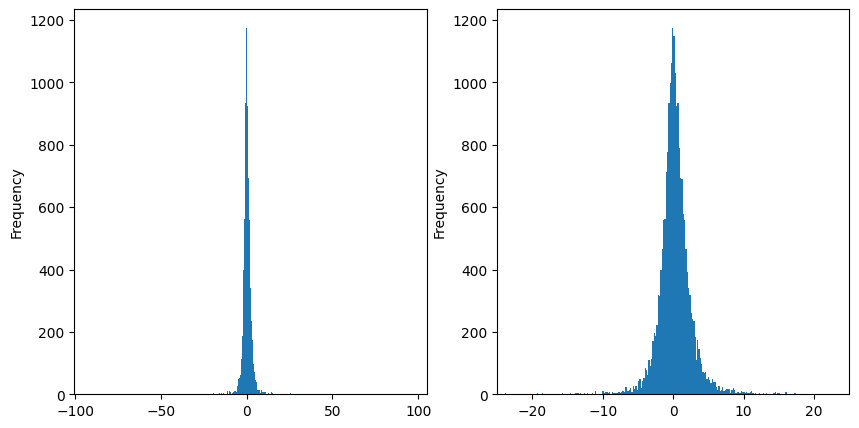

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df['returns'].plot.hist(ax=ax[0], bins=1000)
df['returns'].plot.hist(ax=ax[1], bins=1000, xlim=(-25,25))
plt.show()

In [29]:
print(len(df[df['returns'] < -3]))
print(len(df[df['returns'] > 3]))
print(len(df) - len(df[df['returns'] < -3]) - len(df[df['returns'] > 3]))

1124
1773
18908


In [30]:
dataset = df.drop(['publisher', 'url', 'uuid'], axis=1)

dataset['publish_time'] = pd.to_datetime(dataset['publish_time'], format='%Y-%m-%d %H:%M:%S', utc=True).dt.date
dataset = dataset.groupby(['symbol', 'publish_time']).agg({'title': ' '.join, 'body': ' '.join, 'returns': 'mean'}).reset_index()
# dataset = dataset.groupby(['symbol', 'publish_time']).agg({'title': list, 'body': list, 'returns': 'mean'}).reset_index()

dataset

,symbol,publish_time,title,body,returns
0,A,2023-05-18,Vipshop (VIPS) to Post Q1 Earnings: What's in ...,Vipshop Holdings Limited VIPS is set to report...,1.424434
1,A,2023-05-19,Agilent to Appeal Patent Office Decision on CR...,"SANTA CLARA, Calif., May 19, 2023--(BUSINESS W...",-0.371686
2,A,2023-05-21,"Costco, JPMorgan, Snowflake, Ford, Zoom, and M...","Earnings reports from Zoom Video, Lowe’s, Snow...",-0.162948
3,A,2023-05-24,"Agilent (A) Q2 Earnings Match Estimates, Reven...",Agilent Technologies A reported second-quarter...,-5.620333
4,A,2023-05-26,Louis Navellier’s 2023 Portfolio: 15 Growth St...,"In this article, we discuss 15 growth stocks t...",0.435186
...,...,...,...,...,...
14985,ZTS,2023-08-08,Zoetis (ZTS) Q2 2023 Earnings Call Transcript ...,"Hosting the call today is Steve Frank, vice pr...",5.119265
14986,ZTS,2023-08-09,Drugmaker Zoetis Stock Shows Rising Relative S...,When considering what names to put on your wat...,0.369782
14987,ZTS,2023-08-10,USNA or ZTS: Which Is the Better Value Stock R...,Investors interested in stocks from the Medica...,-0.459472
14988,ZTS,2023-11-09,Top 20 Drug Companies in the US by Revenue,"In this article, we will be taking a look at t...",-0.210687


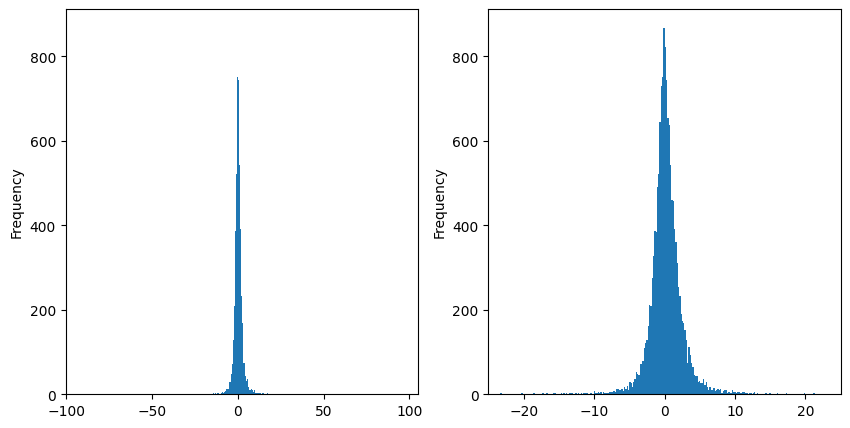

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
dataset['returns'].plot.hist(ax=ax[0], bins=1000)
dataset['returns'].plot.hist(ax=ax[1], bins=1000, xlim=(-25,25))
plt.show()

In [32]:
print(len(dataset[dataset['returns'] < -3]))
print(len(dataset[dataset['returns'] > 3]))
print(len(dataset) - len(dataset[dataset['returns'] < -3]) - len(dataset[dataset['returns'] > 3]))

777
1194
13019


In [33]:
dataset['trend'] = pd.cut(dataset['returns'], bins=[-100, -3, 3, 100], labels=['decrease', 'stable', 'increase'])

dataset

,symbol,publish_time,title,body,returns,trend
0,A,2023-05-18,Vipshop (VIPS) to Post Q1 Earnings: What's in ...,Vipshop Holdings Limited VIPS is set to report...,1.424434,stable
1,A,2023-05-19,Agilent to Appeal Patent Office Decision on CR...,"SANTA CLARA, Calif., May 19, 2023--(BUSINESS W...",-0.371686,stable
2,A,2023-05-21,"Costco, JPMorgan, Snowflake, Ford, Zoom, and M...","Earnings reports from Zoom Video, Lowe’s, Snow...",-0.162948,stable
3,A,2023-05-24,"Agilent (A) Q2 Earnings Match Estimates, Reven...",Agilent Technologies A reported second-quarter...,-5.620333,decrease
4,A,2023-05-26,Louis Navellier’s 2023 Portfolio: 15 Growth St...,"In this article, we discuss 15 growth stocks t...",0.435186,stable
...,...,...,...,...,...,...
14985,ZTS,2023-08-08,Zoetis (ZTS) Q2 2023 Earnings Call Transcript ...,"Hosting the call today is Steve Frank, vice pr...",5.119265,increase
14986,ZTS,2023-08-09,Drugmaker Zoetis Stock Shows Rising Relative S...,When considering what names to put on your wat...,0.369782,stable
14987,ZTS,2023-08-10,USNA or ZTS: Which Is the Better Value Stock R...,Investors interested in stocks from the Medica...,-0.459472,stable
14988,ZTS,2023-11-09,Top 20 Drug Companies in the US by Revenue,"In this article, we will be taking a look at t...",-0.210687,stable


In [34]:
dataset = dataset.drop(dataset[dataset['trend'] == 'stable'].sample(frac=0.9).index).reset_index(drop=True)

dataset

,symbol,publish_time,title,body,returns,trend
0,A,2023-05-21,"Costco, JPMorgan, Snowflake, Ford, Zoom, and M...","Earnings reports from Zoom Video, Lowe’s, Snow...",-0.162948,stable
1,A,2023-05-24,"Agilent (A) Q2 Earnings Match Estimates, Reven...",Agilent Technologies A reported second-quarter...,-5.620333,decrease
2,A,2023-06-07,Agilent (A) Boosts LCMS Portfolio With New Sys...,Agilent Technologies A expanded its liquid chr...,-1.285765,stable
3,A,2023-11-20,Agilent Reports Fourth-Quarter Fiscal Year 202...,Revenue at the high end of guidance and EPS ex...,7.344231,increase
4,AAL,2023-05-22,The Undoing of American and JetBlue’s Northeas...,American Airlines CEO Robert Isom (left) speak...,-3.171385,decrease
...,...,...,...,...,...,...
3396,ZTS,2023-05-30,Zoetis to Participate in the Stifel 2023 Jaws ...,"PARSIPPANY, N.J., May 30, 2023--(BUSINESS WIRE...",-2.270247,stable
3397,ZTS,2023-06-15,Zoetis Releases 2022 Sustainability Report to ...,$7.4 million in corporate giving invested in c...,3.972232,increase
3398,ZTS,2023-06-18,Does Zoetis (NYSE:ZTS) Have A Healthy Balance ...,The external fund manager backed by Berkshire ...,-1.300223,stable
3399,ZTS,2023-08-08,Zoetis (ZTS) Q2 2023 Earnings Call Transcript ...,"Hosting the call today is Steve Frank, vice pr...",5.119265,increase


<Axes: xlabel='trend'>

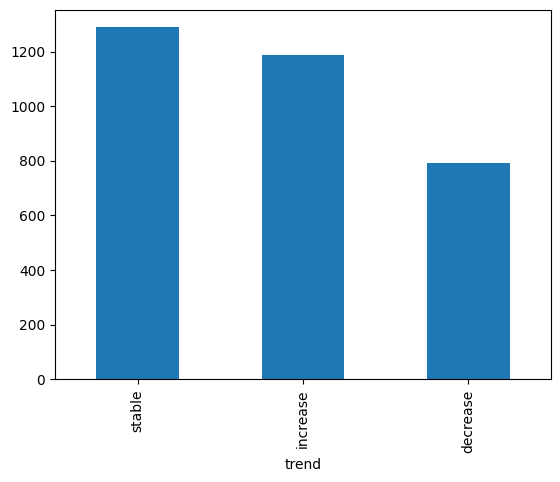

In [35]:
dataset['trend'].value_counts().plot(kind='bar')